In [4]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import keras
from keras.preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from tensorflow.keras.callbacks import TensorBoard

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [7]:
import time
model_name = "non_resized_Conv1D_8_inputs_scaled"
NAME = model_name+"-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

In [8]:
CATEGORIES = ["covid", "normal"]
DATADIR = "D:/Project2022/res/split_dataset/scaled_resized/train"

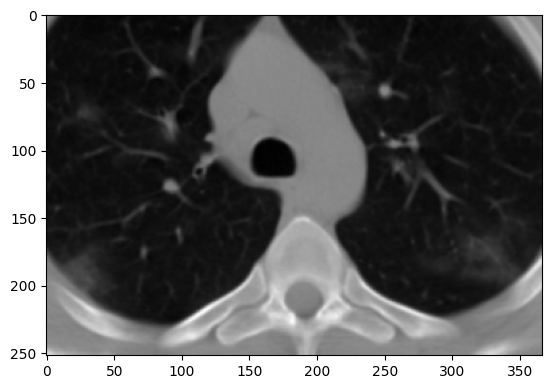

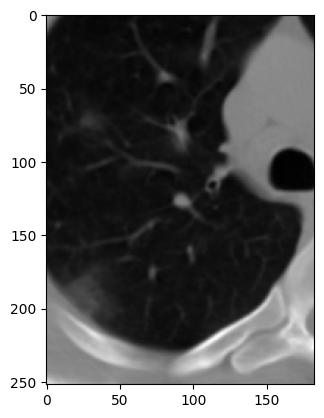

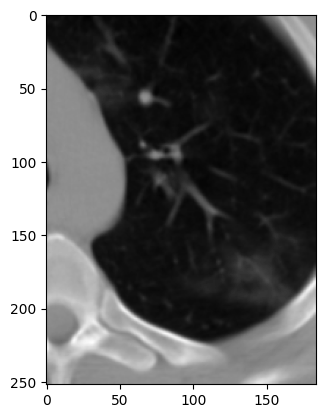

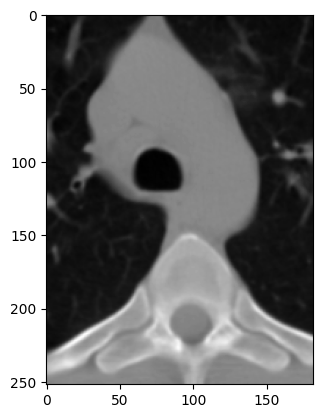

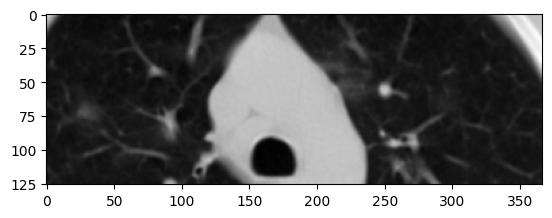

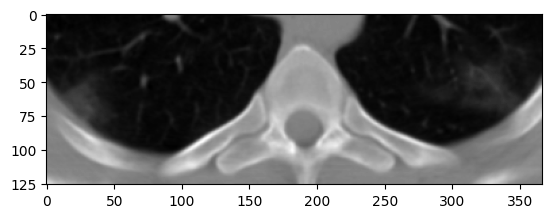

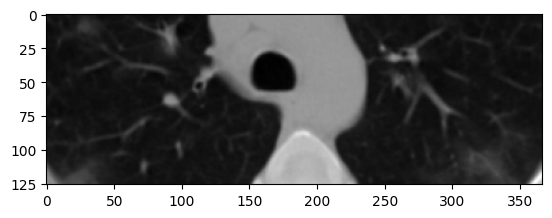

In [10]:
for categoty in CATEGORIES:
    path = os.path.join(DATADIR, categoty)  # path to Covid or Nprmal
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        #img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
        plt.imshow(img_array, cmap="gray")
        plt.show()

        mid_h = int(img_array.shape[1]/4)
        mid_v = int(img_array.shape[0]/4)


        #left half
        LH_img = img_array[: , :int(img_array.shape[1]/2)]
        plt.imshow(LH_img, cmap="gray")
        plt.show()
        
        #Right half
        RH_img = img_array[: , int(img_array.shape[1]/2):]
        plt.imshow(RH_img, cmap="gray")
        plt.show()

        # mid vertical
        mid_ver = img_array[:, int((img_array.shape[1]/2)-mid_h):int((img_array.shape[1]/2)+mid_h)]
        plt.imshow(mid_ver, cmap="gray")
        plt.show()

        #top half
        TC_img = img_array[:int(img_array.shape[0]/2) , :]
        plt.imshow(TC_img, cmap="gray")
        plt.show()

        #bottom half
        BC_img =  img_array[int(img_array.shape[0]/2): , :]
        plt.imshow(BC_img, cmap="gray")
        plt.show()

        #mid horizontal
        mid_hor = img_array[int((img_array.shape[0]/2)-mid_v):int((img_array.shape[0]/2)+mid_v), :]
        plt.imshow(mid_hor, cmap="gray")
        plt.show()


        break
    break

In [11]:
def pre_process_dataset(dataset_path):

    df_data = pd.DataFrame()
    #raw_image = []
    row_sum = []
    coloumn_sum = []
    
    LH_sum = []
    Row_mid = []
    RH_sum = []
    
    TC_sum = []
    Col_mid = []
    BC_sum =[]

    label = []

    for categoty in CATEGORIES:
        path = os.path.join(dataset_path, categoty)  
        
        class_num = CATEGORIES.index(categoty)
        

        print("Loading dataset: class",categoty)
        for img in tqdm(os.listdir(path)):

            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                #img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
                row = img_array.sum(axis=0)
                coloumn = img_array.sum(axis=1)
                mid_h = int(img_array.shape[1]/4)
                mid_v = int(img_array.shape[0]/4)

                #Global inputs
                row_sum.append(row)
                coloumn_sum.append(coloumn)

                #row inputs
                LH_img = img_array[: , :int(img_array.shape[1]/2)]
                LH_sum.append(LH_img.sum(1))

                row_mid = img_array[:, int((img_array.shape[1]/2)-mid_h):int((img_array.shape[1]/2)+mid_h)]
                Row_mid.append(row_mid.sum(1))

                RH_img = img_array[: , int(img_array.shape[1]/2):]
                RH_sum.append(RH_img.sum(1))

                #coloumn inputs
                TC_img = img_array[:int(img_array.shape[0]/2) , :]
                TC_sum.append(TC_img.sum(0))

                col_mid = img_array[int((img_array.shape[0]/2)-mid_v):int((img_array.shape[0]/2)+mid_v), :]
                Col_mid.append(col_mid.sum(0)) 

                BC_img = img_array[int(img_array.shape[0]/2): , :]
                BC_sum.append(BC_img.sum(0))

                
                #raw_image.append(img_array)             

                label.append(class_num)
                
            except Exception as e:
                pass
    
    #df_data["raw data"] = raw_image
    df_data["row_sum"] = row_sum
    df_data["coloumn_sum"] = coloumn_sum

    df_data["LH_sum"] = LH_sum
    df_data["Row_mid"] = Row_mid
    df_data["RH_sum"] = RH_sum


    df_data["TC_sum"] = TC_sum
    df_data["Col_mid"] = Col_mid
    df_data["BC_sum"] = BC_sum

    df_data["label"] = label
    

    return df_data

In [12]:
dataset_df = pre_process_dataset(DATADIR)

Loading dataset: class covid


  0%|          | 0/5719 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/5514 [00:00<?, ?it/s]

In [8]:
dataset_df.head(-1)

,row_sum,coloumn_sum,LH_sum,Row_mid,RH_sum,TC_sum,Col_mid,BC_sum,label
0,"[26099, 25676, 25188, 24716, 24349, 24010, 236...","[15188, 15165, 15034, 14946, 14851, 14789, 147...","[26099, 25676, 25188, 24716, 24349, 24010, 236...","[17257, 17308, 17206, 16999, 16791, 16593, 164...","[55047, 55336, 55679, 55849, 55961, 55943, 558...","[15188, 15165, 15034, 14946, 14851, 14789, 147...","[21553, 21452, 21389, 21353, 21375, 21402, 214...","[21073, 20901, 20722, 20493, 20225, 19897, 194...",0
1,"[73474, 73717, 73998, 74214, 74359, 74470, 746...","[78050, 78059, 78168, 78281, 78422, 78550, 786...","[73474, 73717, 73998, 74214, 74359, 74470, 746...","[77740, 77757, 77889, 77900, 77824, 77769, 776...","[85422, 85439, 85490, 85738, 86159, 86663, 871...","[78050, 78059, 78168, 78281, 78422, 78550, 786...","[80761, 80846, 80960, 81062, 81138, 81227, 812...","[80046, 79912, 79781, 79654, 79494, 79366, 792...",0
2,"[76642, 76817, 77127, 77520, 77719, 77849, 779...","[75406, 75193, 74807, 74522, 74382, 74313, 743...","[76642, 76817, 77127, 77520, 77719, 77849, 779...","[57051, 56886, 56925, 57015, 56670, 56043, 552...","[79862, 79614, 79340, 79161, 79080, 78984, 790...","[75406, 75193, 74807, 74522, 74382, 74313, 743...","[67445, 67451, 67515, 67602, 67720, 67816, 678...","[66811, 66740, 66607, 66396, 66054, 65654, 651...",0
3,"[53413, 53410, 53496, 53710, 53849, 54026, 542...","[49764, 49674, 49607, 49614, 49681, 49754, 498...","[53413, 53410, 53496, 53710, 53849, 54026, 542...","[16925, 16914, 16893, 16670, 16451, 16281, 162...","[56771, 56859, 57095, 57166, 57177, 57220, 575...","[49764, 49674, 49607, 49614, 49681, 49754, 498...","[29631, 29718, 29789, 29884, 29953, 30033, 301...","[28171, 28202, 28304, 28359, 28393, 28397, 283...",0
4,"[48830, 49179, 49634, 50119, 50160, 50264, 503...","[40579, 40502, 40367, 40241, 40157, 40100, 400...","[48830, 49179, 49634, 50119, 50160, 50264, 503...","[24655, 24666, 24556, 24521, 24443, 24219, 237...","[60037, 60186, 60265, 60663, 61459, 62813, 645...","[40579, 40502, 40367, 40241, 40157, 40100, 400...","[47174, 46966, 46706, 46388, 46022, 45673, 454...","[17165, 16952, 16759, 16618, 16559, 16619, 168...",0
...,...,...,...,...,...,...,...,...,...
11227,"[77073, 77674, 78399, 79040, 79015, 78901, 787...","[69335, 69057, 68479, 67895, 67302, 66655, 659...","[77073, 77674, 78399, 79040, 79015, 78901, 787...","[50968, 51052, 51157, 51223, 51262, 51273, 511...","[79387, 78864, 78314, 77927, 77636, 77320, 770...","[69335, 69057, 68479, 67895, 67302, 66655, 659...","[58016, 58131, 58269, 58323, 58281, 58228, 581...","[56939, 56877, 56834, 56809, 56732, 56732, 567...",1
11228,"[68286, 68935, 69634, 70079, 69976, 69901, 699...","[60614, 60424, 60035, 59813, 59764, 59777, 598...","[68286, 68935, 69634, 70079, 69976, 69901, 699...","[59468, 59371, 59349, 59337, 59307, 59343, 594...","[74329, 74503, 74887, 75443, 76056, 76493, 766...","[60614, 60424, 60035, 59813, 59764, 59777, 598...","[66958, 66770, 66528, 66328, 66130, 65942, 658...","[46095, 46168, 46242, 46313, 46377, 46450, 465...",1
11229,"[77895, 77209, 76363, 75413, 74768, 74269, 737...","[65379, 64215, 61859, 59863, 58356, 57253, 566...","[77895, 77209, 76363, 75413, 74768, 74269, 737...","[45475, 46049, 46538, 46848, 47072, 47252, 473...","[74458, 74633, 74934, 75155, 75397, 75540, 756...","[65379, 64215, 61859, 59863, 58356, 57253, 566...","[53799, 53779, 53802, 53828, 53904, 53993, 541...","[51190, 50941, 50566, 50164, 49703, 49345, 491...",1
11230,"[68831, 68766, 68644, 68482, 68493, 68598, 688...","[76030, 76013, 76063, 76113, 76181, 76248, 763...","[68831, 68766, 68644, 68482, 68493, 68598, 688...","[65699, 65613, 65534, 65435, 65288, 65150, 650...","[78803, 78765, 78653, 78493, 78316, 78102, 779...","[76030, 76013, 76063, 76113, 76181, 76248, 763...","[77646, 77611, 77659, 77713, 77779, 77813, 778...","[72727, 72652, 72607, 72591, 72664, 72721, 727...",1


In [13]:
df_train, df_val = train_test_split(dataset_df, test_size=0.2, random_state=0)

In [14]:
df_train["label"].value_counts()

0    4601
1    4385
Name: label, dtype: int64

In [15]:
print("No of Training samples:",len(df_train))
print("No of Validation samples:",len(df_val))

No of Training samples: 8986
No of Validation samples: 2247


In [18]:
df_train["Row_mid"][0].shape

(252,)

In [19]:
from sklearn import preprocessing

def process_data(dataset_df):
    
    row = dataset_df["row_sum"].values
    coloumn = dataset_df["coloumn_sum"].values

    LH = dataset_df["LH_sum"].values
    Row_mid = dataset_df["Row_mid"].values
    RH = dataset_df["RH_sum"].values


    TC = dataset_df["TC_sum"].values
    Col_mid = dataset_df["Col_mid"].values
    BC = dataset_df["BC_sum"].values

    # global
    X1 = [img.tolist() for img in row]
    X2 = [img.tolist() for img in coloumn]

    #row
    X3 = [img.tolist() for img in LH]
    X_row_mid = [img.tolist() for img in Row_mid]
    X4 = [img.tolist() for img in RH]

    #coloumn
    X5 = [img.tolist() for img in TC]
    X_col_mid = [img.tolist() for img in Col_mid]
    X6 = [img.tolist() for img in BC]


    X1 = np.array(X1)
    X2 = np.array(X2)

    X3 = np.array(X3)
    X_row_mid = np.array(X_row_mid)
    X4 = np.array(X4)


    X5 = np.array(X5)
    X_col_mid = np.array(X_col_mid)
    X6 = np.array(X6)

    #normalize the inputs
    X1 = preprocessing.normalize(X1)
    X2 = preprocessing.normalize(X2)

    X3 = preprocessing.normalize(X3)
    X_row_mid = preprocessing.normalize(X_row_mid)
    X4 = preprocessing.normalize(X4)

    X5 = preprocessing.normalize(X5)
    X_col_mid = preprocessing.normalize(X_col_mid)
    X6 = preprocessing.normalize(X6)

    #reshape the inputs
    X1 = np.expand_dims(X1, axis=-1)
    X2 = np.expand_dims(X2, axis=-1)

    X3 = np.expand_dims(X3, axis=-1)
    X_row_mid = np.expand_dims(X_row_mid, axis=-1)
    X4 = np.expand_dims(X4, axis=-1)

    X5 = np.expand_dims(X5, axis=-1)
    X_col_mid = np.expand_dims(X_col_mid, axis=-1)
    X6 = np.expand_dims(X6, axis=-1)



    y = np.array(dataset_df["label"].values)
    y = np.expand_dims(y, axis=-1)


    print("X1 shape", X1.shape)
    print("X2 shape", X2.shape)

    print("X3 shape", X3.shape)
    print("Mid rows shape", X_row_mid.shape)
    print("X4 shape", X4.shape)

    print("X5 shape", X5.shape)
    print("Mid Cols shape", X_col_mid.shape)
    print("X6 shape", X6.shape)

    print("y shape", y.shape)

    return X1, X2, X3, X_row_mid, X4, X5, X_col_mid, X6, y

In [20]:
print("Training samples:")
X1_train, X2_train, X3_train, X_row_mid, X4_train, X5_train, X_col_mid, X6_train, Y_train = process_data(df_train)

print("\nValidation samples:")
X1_val, X2_val, X3_val, X_row_mid_val, X4_val, X5_val, X_mid_col_val, X6_val, Y_val = process_data(df_val)


Training samples:
X1 shape (8986, 367, 1)
X2 shape (8986, 252, 1)
X3 shape (8986, 252, 1)
Mid rows shape (8986, 252, 1)
X4 shape (8986, 252, 1)
X5 shape (8986, 367, 1)
Mid Cols shape (8986, 367, 1)
X6 shape (8986, 367, 1)
y shape (8986, 1)

Validation samples:
X1 shape (2247, 367, 1)
X2 shape (2247, 252, 1)
X3 shape (2247, 252, 1)
Mid rows shape (2247, 252, 1)
X4 shape (2247, 252, 1)
X5 shape (2247, 367, 1)
Mid Cols shape (2247, 367, 1)
X6 shape (2247, 367, 1)
y shape (2247, 1)


In [15]:
# first input model
row = Input(shape=(512,1))
conv11 = Conv1D(64, kernel_size=3, activation='relu')(row)
conv12 = Conv1D(64, kernel_size=3, activation='relu')(conv11)
drop11 = Dropout(0.25)(conv12)
pool11 = MaxPooling1D(pool_size=2)(drop11)
flat_row = Flatten()(pool11)


# second input model
col = Input(shape=(512,1))
conv21 = Conv1D(64, kernel_size=3, activation='relu')(col)
conv22 = Conv1D(64, kernel_size=3, activation='relu')(conv21)
drop21 = Dropout(0.25)(conv22)
pool21 = MaxPooling1D(pool_size=2)(drop21)
flat_col = Flatten()(pool21)

# merge input models
merge = concatenate([flat_row, flat_col])

hidden1 = Dense(100, activation='relu')(merge)
hidden_global = Dense(100, activation='relu')(hidden1)

#####################################################################

LH = Input(shape=(256,1))
conv31 = Conv1D(64, kernel_size=3, activation='relu')(LH)
conv32 = Conv1D(64, kernel_size=3, activation='relu')(conv31)
drop31 = Dropout(0.25)(conv32)
pool31 = MaxPooling1D(pool_size=2)(drop31)
flat3 = Flatten()(pool31)

row_mid = Input(shape=(256,1))
conv41 = Conv1D(64, kernel_size=3, activation='relu')(row_mid)
conv42 = Conv1D(64, kernel_size=3, activation='relu')(conv41)
drop41 = Dropout(0.25)(conv42)
pool41 = MaxPooling1D(pool_size=2)(drop41)
flat4 = Flatten()(pool41)

RH = Input(shape=(256,1))
conv51 = Conv1D(64, kernel_size=3, activation='relu')(RH)
conv52 = Conv1D(64, kernel_size=3, activation='relu')(conv51)
drop51 = Dropout(0.25)(conv52)
pool51 = MaxPooling1D(pool_size=2)(drop51)
flat5 = Flatten()(pool51)

# merge input models
merge_rows = concatenate([flat3, flat4, flat5])
hidden3 = Dense(100, activation='relu')(merge_rows)
hidden_rows = Dense(100, activation='relu')(hidden3)




TC = Input(shape=(256,1))
conv61 = Conv1D(64, kernel_size=3, activation='relu')(TC)
conv62 = Conv1D(64, kernel_size=3, activation='relu')(conv61)
drop61 = Dropout(0.25)(conv62)
pool61 = MaxPooling1D(pool_size=2)(drop61)
flat6 = Flatten()(pool61)

col_mid = Input(shape=(256,1))
conv71 = Conv1D(64, kernel_size=3, activation='relu')(col_mid)
conv72 = Conv1D(64, kernel_size=3, activation='relu')(conv71)
drop71 = Dropout(0.25)(conv72)
pool71 = MaxPooling1D(pool_size=2)(drop71)
flat7 = Flatten()(pool71)

BC = Input(shape=(256,1))
conv81 = Conv1D(64, kernel_size=3, activation='relu')(BC)
conv82 = Conv1D(64, kernel_size=3, activation='relu')(conv81)
drop81 = Dropout(0.25)(conv82)
pool81 = MaxPooling1D(pool_size=2)(drop81)
flat8 = Flatten()(pool81)



merge_cols = concatenate([flat6, flat7, flat8])
hidden5 = Dense(100, activation='relu')(merge_cols)
hidden_cols = Dense(100, activation='relu')(hidden5)

# merge input models
merge_row_col = concatenate([hidden_rows, hidden_cols])
merge_all = concatenate([hidden_global, merge_row_col])

output = Dense(1, activation='sigmoid')(merge_all)
model = Model(inputs=[row, col, LH, row_mid, RH, TC, col_mid, BC], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 1)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 1)]     0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 256, 1)]     0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 256, 1)]     0           []                               
                                                                                              

In [7]:
# first input model
visible1 = Input(shape=(512,1))
conv11 = Conv1D(64, kernel_size=3, activation='relu')(visible1)

conv12 = Conv1D(64, kernel_size=3, activation='relu')(conv11)
drop11 = Dropout(0.25)(conv12)
pool11 = MaxPooling1D(pool_size=2)(drop11)
flat1 = Flatten()(pool11)


# second input model

visible2 = Input(shape=(512,1))
conv21 = Conv1D(64, kernel_size=3, activation='relu')(visible2)
conv22 = Conv1D(64, kernel_size=3, activation='relu')(conv21)
drop21 = Dropout(0.25)(conv22)
pool21 = MaxPooling1D(pool_size=2)(drop21)
flat2 = Flatten()(pool21)


# merge input models
merge = concatenate([flat1, flat2])
# interpretation model
hidden1 = Dense(100, activation='relu')(merge)
hidden2 = Dense(100, activation='relu')(hidden1)

output = Dense(1, activation='sigmoid')(hidden2)
model = Model(inputs=[visible1, visible2], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize layers
print(model.summary())

## Modified

In [21]:
# first input model
row = Input(shape=(367,1))
#kernel size 5
conv11 = Conv1D(64, kernel_size=5, activation='relu')(row)
#16
conv12 = Conv1D(32, kernel_size=5, activation='relu')(conv11)
drop11 = Dropout(0.25)(conv12)
pool11 = MaxPooling1D(pool_size=2)(drop11)
flat_row = Flatten()(pool11)


# second input model
col = Input(shape=(252,1))
conv21 = Conv1D(64, kernel_size=5, activation='relu')(col)
conv22 = Conv1D(32, kernel_size=5, activation='relu')(conv21)
drop21 = Dropout(0.25)(conv22)
pool21 = MaxPooling1D(pool_size=2)(drop21)
flat_col = Flatten()(pool21)

# merge input models
#merge = concatenate([flat_row, flat_col])

#hidden1 = Dense(100, activation='relu')(merge)
#hidden_global = Dense(100, activation='relu')(hidden1)

#####################################################################

LH = Input(shape=(252,1))
conv31 = Conv1D(64, kernel_size=5, activation='relu')(LH)
conv32 = Conv1D(32, kernel_size=5, activation='relu')(conv31)
drop31 = Dropout(0.25)(conv32)
pool31 = MaxPooling1D(pool_size=2)(drop31)
flat3 = Flatten()(pool31)

row_mid = Input(shape=(252,1))
conv41 = Conv1D(64, kernel_size=5, activation='relu')(row_mid)
conv42 = Conv1D(32, kernel_size=5, activation='relu')(conv41)
drop41 = Dropout(0.25)(conv42)
pool41 = MaxPooling1D(pool_size=2)(drop41)
flat4 = Flatten()(pool41)

RH = Input(shape=(252,1))
conv51 = Conv1D(64, kernel_size=5, activation='relu')(RH)
conv52 = Conv1D(32, kernel_size=5, activation='relu')(conv51)
drop51 = Dropout(0.25)(conv52)
pool51 = MaxPooling1D(pool_size=2)(drop51)
flat5 = Flatten()(pool51)


TC = Input(shape=(367,1))
conv61 = Conv1D(64, kernel_size=5, activation='relu')(TC)
conv62 = Conv1D(32, kernel_size=5, activation='relu')(conv61)
drop61 = Dropout(0.25)(conv62)
pool61 = MaxPooling1D(pool_size=2)(drop61)
flat6 = Flatten()(pool61)

col_mid = Input(shape=(367,1))
conv71 = Conv1D(64, kernel_size=5, activation='relu')(col_mid)
conv72 = Conv1D(32, kernel_size=5, activation='relu')(conv71)
drop71 = Dropout(0.25)(conv72)
pool71 = MaxPooling1D(pool_size=2)(drop71)
flat7 = Flatten()(pool71)

BC = Input(shape=(367,1))
conv81 = Conv1D(64, kernel_size=5, activation='relu')(BC)
conv82 = Conv1D(32, kernel_size=5, activation='relu')(conv81)
drop81 = Dropout(0.25)(conv82)
pool81 = MaxPooling1D(pool_size=2)(drop81)
flat8 = Flatten()(pool81)



merge_all = concatenate([flat_row, flat_col, flat3, flat4, flat5, flat6, flat7, flat8])
hidden_all_1 = Dense(128, activation='relu')(merge_all)
hidden_all_2 = Dense(64, activation='relu')(hidden_all_1)

output = Dense(1, activation='sigmoid')(hidden_all_2)
model = Model(inputs=[row, col, LH, row_mid, RH, TC, col_mid, BC], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 367, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 252, 1)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 252, 1)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 252, 1)]     0           []                               
                                                                                              

In [22]:

BATCH_SIZE = 128
EPOCHS = 500
history = model.fit(
    [X1_train, X2_train, X3_train, X_row_mid, X4_train, X5_train, X_col_mid, X6_train],
    Y_train,
    BATCH_SIZE,
    EPOCHS,
    validation_data=([X1_val, X2_val, X3_val, X_row_mid_val, X4_val, X5_val, X_mid_col_val, X6_val], Y_val),
    callbacks=[tensorboard])

model.save("D:/Project2022/models/"+model_name+".h5")

Epoch 1/500
71/71 [==============================] - 16s 68ms/step - loss: 0.5916 - accuracy: 0.6957 - val_loss: 0.5059 - val_accuracy: 0.7641
Epoch 2/500
71/71 [==============================] - 4s 51ms/step - loss: 0.4403 - accuracy: 0.7962 - val_loss: 0.4248 - val_accuracy: 0.8149
Epoch 3/500
71/71 [==============================] - 4s 50ms/step - loss: 0.4000 - accuracy: 0.8231 - val_loss: 0.3717 - val_accuracy: 0.8500
Epoch 4/500
71/71 [==============================] - 4s 50ms/step - loss: 0.3706 - accuracy: 0.8429 - val_loss: 0.3508 - val_accuracy: 0.8660
Epoch 5/500
71/71 [==============================] - 4s 50ms/step - loss: 0.3582 - accuracy: 0.8479 - val_loss: 0.3410 - val_accuracy: 0.8585
Epoch 6/500
71/71 [==============================] - 4s 49ms/step - loss: 0.3442 - accuracy: 0.8584 - val_loss: 0.3251 - val_accuracy: 0.8683
Epoch 7/500
71/71 [==============================] - 4s 50ms/step - loss: 0.3259 - accuracy: 0.8700 - val_loss: 0.3195 - val_accuracy: 0.8709
Epoch

In [4]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [3]:
import keras
model_name = "mutiple_Conv1D_8_inputs_scaled_modified"
model = keras.models.load_model("D:/Project2022/models/"+model_name+".h5")

In [8]:
from keras_visualizer import visualizer
visualizer(model, format='png', view=True)


ValueError: Keras Visualizer: Layer not supported for visualizing

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
pip install keras-visualizer

Note: you may need to restart the kernel to use updated packages.


In [16]:
model_name

'mutiple_Conv1D_8_inputs_scaled_modified'

In [15]:
model.save("D:/Project2022/models/"+model_name+".h5")

ImportError: `save_model()` using h5 format requires h5py. Could not import h5py.

In [7]:
#model = keras.models.load_model("D:/Project2022/models/image/raw_500.h5")

#from tensorflow import keras
bing = keras.models.load_model('D:/Project2022/models/image/raw_500.h5')
bing.save(model_name+".h5")


ImportError: Filepath looks like a hdf5 file but h5py is not available. filepath=D:/Project2022/models/image/raw_500.h5

In [34]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [33]:

model.save("D:/Project2022/models/image/delete.h5")

ImportError: DLL load failed while importing defs: The specified procedure could not be found.

# Evaluate the Model using test data

In [23]:
Test_DATADIR = "D:/Project2022/res/split_dataset/scaled_resized/test"
dataset_df = pre_process_dataset(Test_DATADIR)


Loading dataset: class covid


  0%|          | 0/1430 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/1379 [00:00<?, ?it/s]

In [24]:
print("No of test sample:", len(dataset_df))

No of test sample: 2809


In [25]:
X1_test, X2_test, X3_test, X_row_mid_test, X4_test, X5_test, X_col_mid_test, X6_test, Y_test = process_data(dataset_df)

X1 shape (2809, 367, 1)
X2 shape (2809, 252, 1)
X3 shape (2809, 252, 1)
Mid rows shape (2809, 252, 1)
X4 shape (2809, 252, 1)
X5 shape (2809, 367, 1)
Mid Cols shape (2809, 367, 1)
X6 shape (2809, 367, 1)
y shape (2809, 1)


In [26]:
# test loss, test accuracy
accuracy = model.evaluate([X1_test, X2_test, X3_test, X_row_mid_test, X4_test, X5_test, X_col_mid_test, X6_test], Y_test, batch_size=100, verbose=0)

In [27]:
print("Test acuuracy", accuracy[1])
print("Test loss", accuracy[0])

Test acuuracy 0.9619081616401672
Test loss 0.20270198583602905


In [28]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict([X1_test, X2_test, X3_test, X_row_mid_test, X4_test, X5_test, X_col_mid_test, X6_test]) > 0.5).astype("int32")

88/88 [==============================] - 2s 10ms/step


In [29]:
print(classification_report(Y_test, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.97      0.96      0.96      1430
      Normal       0.96      0.97      0.96      1379

    accuracy                           0.96      2809
   macro avg       0.96      0.96      0.96      2809
weighted avg       0.96      0.96      0.96      2809



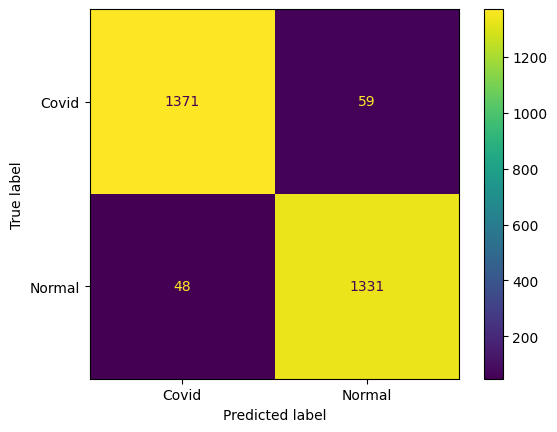

In [30]:
cm = confusion_matrix(Y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()
